In [35]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

In [3]:
faces.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [4]:
print(faces.target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


In [5]:
print(faces.images.shape)

(1348, 62, 47)


There are 1348 images and each one is 62 x 47 pixels.

Let's print some of these faces to see what they look like.

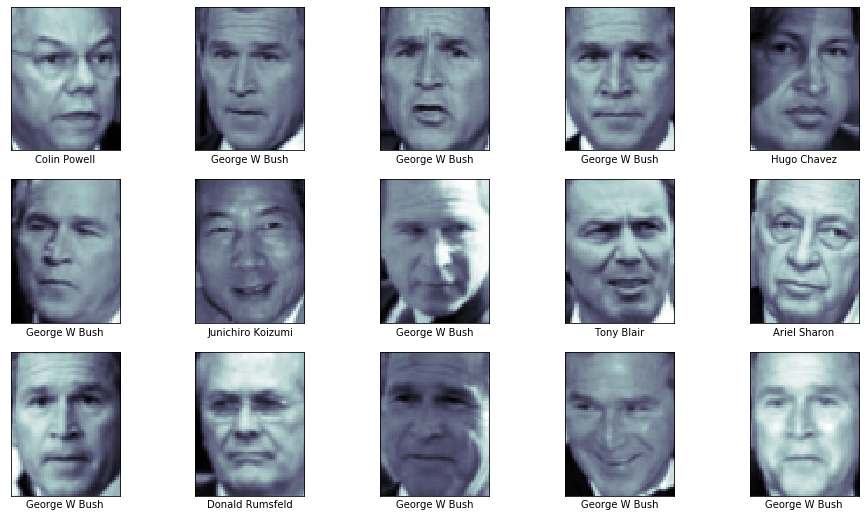

In [6]:
fig, ax = plt.subplots(3, 5, figsize=(16, 9))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [23]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Keep 150 componenets and uncorrelated outputs
pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)

# Radial Basis Function and C set to balanced 
svm = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svm)

In [24]:
# Split the data
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

Text(0, 0.5, 'cumulative explained variance')

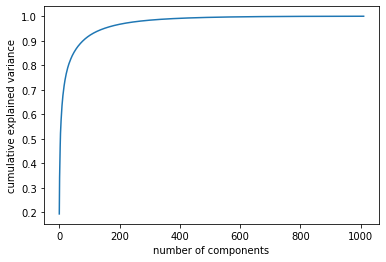

In [25]:
# Let's see how many components will serve our data
testComponents = PCA().fit(Xtrain)
plt.plot(np.cumsum(testComponents.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

150 components serves about 90% of our data - which is great!

In [26]:
# Grid Search to find optimal parameters
from sklearn.model_selection import GridSearchCV

param_grid = {'svc__C' : [1, 5, 10, 50],
         'svc__gamma' : [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

C:\Users\Nino\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Wall time: 10.2 s
{'svc__C': 10, 'svc__gamma': 0.001}


In [27]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

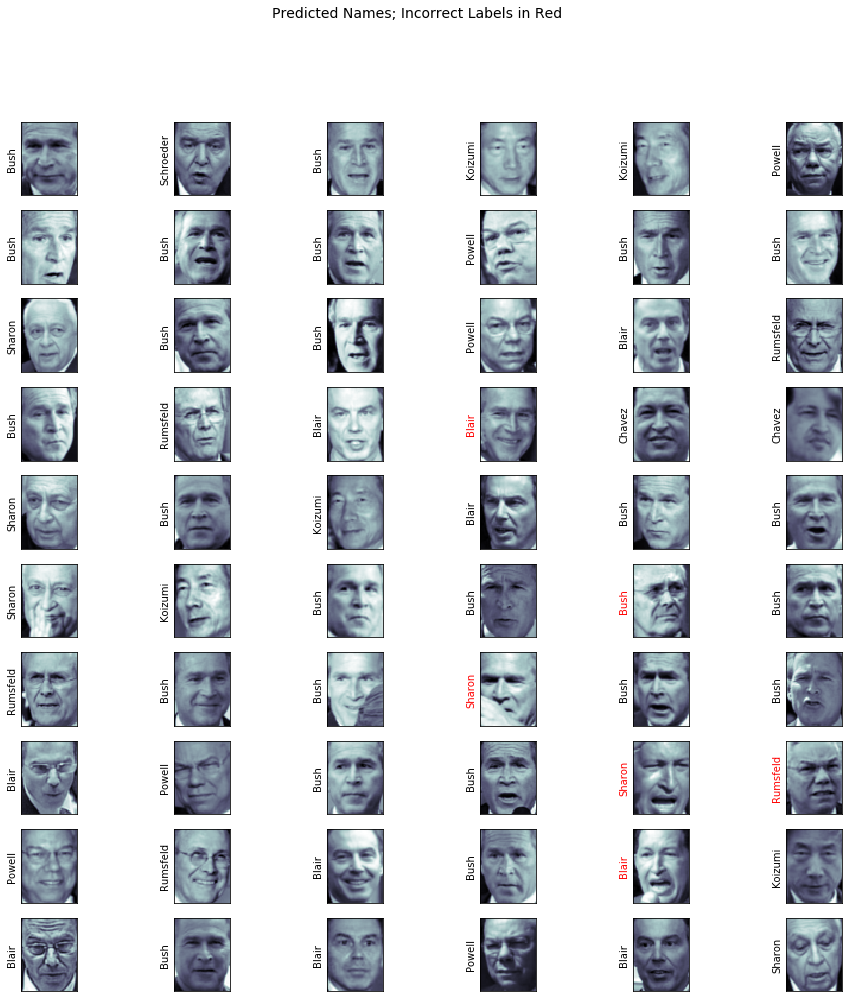

In [28]:
fig, ax = plt.subplots(10, 6, figsize=(16, 16))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1], color='black' if yfit[i] == ytest[i] else 'red')
    
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

Classification Report will give us a better sense of how our model performed by listing recovery statistics label by label.

In [29]:
from sklearn.metrics import classification_report

print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



Our precision tells us if our predicted faces of each person was actually that person.

Our recall tells us if we have correctly detected all faces of the person we are looking for.

Text(256.2714285714286, 0.5, 'predicted label')

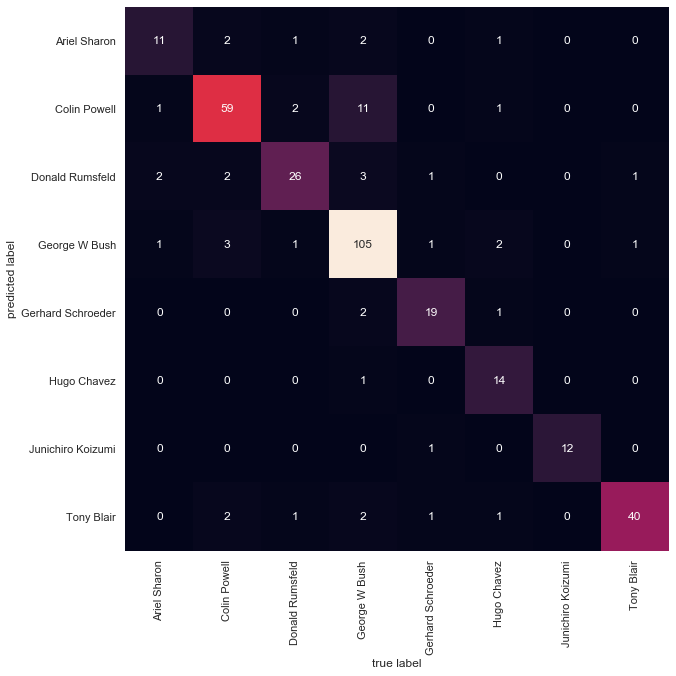

In [34]:
from sklearn.metrics import confusion_matrix


fig, ax = plt.subplots(figsize=(16, 10))
mat = confusion_matrix(ytest, yfit)
t = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names, 
            yticklabels=faces.target_names)
bottom, top = t.get_ylim()
t.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('true label')
plt.ylabel('predicted label')